In [114]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score

# Preprocessing data

In [115]:
data = pandas.read_csv('data/cardio_train1.csv')
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [116]:
categorical_features = ['smoke', 'alco', 'active']
for feature in categorical_features:
    relation = (data[feature] == data['cardio']).sum() / len(data.index)
    print(f"Number of samples where feature {feature} = cardio: {relation}")

gender_relation = (data['gender'] - 1 == data['cardio']).sum() / len(data.index)
print(f"Number of samples where feature gender = cardio: {gender_relation}")


Number of samples where feature smoke = cardio: 0.49585714285714283
Number of samples where feature alco = cardio: 0.49861428571428573
Number of samples where feature active = cardio: 0.48565714285714284
Number of samples where feature gender = cardio: 0.5039571428571429


In [117]:
continous_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
# for feature, i in zip(continous_features, range(len(continous_features))):
#     # plt.subplot(i+1, 1, 1)
#     plt.plot(feature, 'cardio', 'r+', data=data)
#     plt.xlabel(feature)
#     plt.ylabel('cardio')
#     plt.show()

In [118]:
# cardio is our labels
features = data.drop(['id', 'cardio'], axis=1)
output = data['cardio']

features.isnull().any()

age            False
gender         False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
dtype: bool

## Defining X and y and splitting data into train, validation and test sets

In [119]:
train_split_factor = 0.6
val_split_factor = 0.2
train_split = int(train_split_factor * features.shape[0])
val_split = int(train_split + val_split_factor * features.shape[0])

X_train = features.iloc[:train_split]
y_train = output.iloc[:train_split]
X_val = features.iloc[train_split:val_split]
y_val = output.iloc[train_split:val_split]
X_test = features.iloc[val_split:]
y_test = output.iloc[val_split:]

## Scaling the features

We scale only numerical data, we don't want to scale categorical features.

I decided to use MinMaxScaler, because using StandardScaler led to the error reaching NaN value

In [120]:
features_to_scale = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
scaler = MinMaxScaler(copy=False)
scaled_features = scaler.fit_transform(X_train[features_to_scale])

other_features = X_train.drop(features_to_scale, axis=1).to_numpy()
X_train = np.concatenate((scaled_features, other_features), axis=1)

X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
y_train = np.asmatrix(y_train.to_numpy()).T

Preparing validation set

In [121]:
scaled_features = scaler.transform(X_val[features_to_scale])
other_features = X_val.drop(features_to_scale, axis=1).to_numpy()

X_val = np.concatenate((scaled_features, other_features), axis=1)

X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1)
y_val = np.asmatrix(y_val.to_numpy()).T

Preparing test set

In [122]:
scaled_features = scaler.transform(X_test[features_to_scale])
other_features = X_test.drop(features_to_scale, axis=1).to_numpy()

X_test = np.concatenate((scaled_features, other_features), axis=1)

X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
y_test = np.asmatrix(y_test.to_numpy()).T

# Logistic regression functions

In [123]:
def perform_mini_batch_gradient_descent(X, y, alpha=0.01, n_epochs=3, batch_size=32, lambda_param=0):
    theta = np.ones((X.shape[1], 1))
    error_list = []
    m = batch_size
    for i in range(n_epochs):
        mini_batches = create_mini_batches(X, y, batch_size)
        for batch in mini_batches:
            X_batch, y_batch = batch
            theta -= alpha * calculate_gradient(X_batch, y_batch, theta, lambda_param)
            error_list.append(calculate_cost(X_batch, y_batch, theta, lambda_param))

    return theta, error_list


def create_mini_batches(X, y, batch_size):
    mini_batches = []
    random_indices = np.random.permutation(X.shape[0])
    last_index = 0

    for i in range(0, X.shape[0] - batch_size, batch_size):
        mini_batch_idx = random_indices[i: i + batch_size]
        X_mini_batch = X[mini_batch_idx]
        y_mini_batch = y[mini_batch_idx]
        mini_batches.append((X_mini_batch, y_mini_batch))
        last_index = i + batch_size

    if last_index < X.shape[0]:
        mini_batch_idx = random_indices[last_index:]
        X_mini_batch = X[mini_batch_idx]
        y_mini_batch = y[mini_batch_idx]
        mini_batches.append((X_mini_batch, y_mini_batch))

    return mini_batches


def calculate_gradient(X, y, theta, lambda_param=0):
    m = X.shape[0]
    hypothesis = sigmoid(X, theta)
    gradient = 1/m * X.T.dot(hypothesis - y)
    # we don't regularize the bias (theta[0])
    regularization = lambda_param / m * np.concatenate(([[0]], theta[1:]), axis=0)
    return gradient + regularization


def sigmoid(X, theta):
    Z = X.dot(theta)
    return 1 / (1 + np.exp(-Z))


def calculate_cost(X, y, theta, lambda_param=0):
    m = X.shape[0]  # number of samples
    hypothesis = sigmoid(X, theta)
    cost = -1/m * (y.T.dot(np.log(hypothesis)) +
                   (1 - y).T.dot(np.log(1 - hypothesis)))
    regularization = lambda_param / (2*m) * np.sum(np.abs(theta[1:]))
    return cost.item((0, 0)) + regularization


def predict_y(X, theta):
    return (sigmoid(X, theta) >= 0.5).astype(np.int)

## Training the model

In [124]:
best_alpha = 0.01
best_lambda = 0

best_error = 10**10

alpha_values = [10**i for i in range(-4, 1)]
lambda_values = [0.01 * 2**i for i in range(0, 15)]
lambda_values.append(0)

for alpha in alpha_values:
    for lambda_param in lambda_values:
        theta, error_list = perform_mini_batch_gradient_descent(X_train, y_train, alpha=alpha, n_epochs=2, batch_size=32, lambda_param=lambda_param)

        cross_validation_error = calculate_cost(X_val, y_val, theta, lambda_param=0)
        print(f'Gradient descent for [alpha: {alpha}, lambda: {lambda_param}] completed')
        print(f'Acquired cost: {cross_validation_error}')

        if cross_validation_error < best_error:
            best_error = cross_validation_error
            best_alpha = alpha
            best_lambda = lambda_param

print(f'Best parameters: alpha: {best_alpha}, lambda: {best_lambda}')

Gradient descent for [alpha: 0.0001, lambda: 0.01] completed
Acquired cost: 3.1525851571756514
Gradient descent for [alpha: 0.0001, lambda: 0.02] completed
Acquired cost: 3.1523431045059405
Gradient descent for [alpha: 0.0001, lambda: 0.04] completed
Acquired cost: 3.151853248059782
Gradient descent for [alpha: 0.0001, lambda: 0.08] completed
Acquired cost: 3.1509051288974064
Gradient descent for [alpha: 0.0001, lambda: 0.16] completed
Acquired cost: 3.1490372579313326
Gradient descent for [alpha: 0.0001, lambda: 0.32] completed
Acquired cost: 3.1452385758281376
Gradient descent for [alpha: 0.0001, lambda: 0.64] completed
Acquired cost: 3.137624054235371
Gradient descent for [alpha: 0.0001, lambda: 1.28] completed
Acquired cost: 3.1224823541951925
Gradient descent for [alpha: 0.0001, lambda: 2.56] completed
Acquired cost: 3.0924706801542374
Gradient descent for [alpha: 0.0001, lambda: 5.12] completed
Acquired cost: 3.0334811428554422
Gradient descent for [alpha: 0.0001, lambda: 10.24] 

Text(0, 0.5, 'Logistic regularized error')

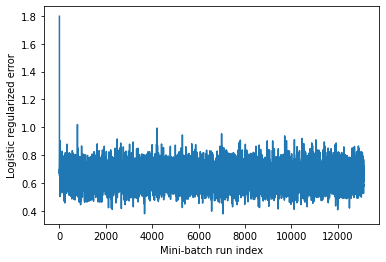

In [125]:
theta, error_list = perform_mini_batch_gradient_descent(X_train, y_train, alpha=best_alpha, n_epochs=10, batch_size=32, lambda_param=best_lambda)
plt.plot(error_list)
plt.xlabel('Mini-batch run index')
plt.ylabel('Logistic regularized error')

# Checking the model on the test set

In [126]:
test_cost = calculate_cost(X_test, y_test, theta)
print(f"Cost acquired on the test set is {test_cost}")

predictions = predict_y(X_test, theta)

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
print(f"Acquired precision: {precision}")
print(f"Acquired recall: {recall}")

Cost acquired on the test set is 0.6354165203988097
Acquired precision: 0.6405822164577029
Acquired recall: 0.6342751141552512
